In [1]:
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob

In [3]:
with open("./Data/DataSplit2.csv", "r") as f:
    reader = csv.reader(f)
    data = list(reader)
classes = [int(i[1]) for i in data if i[2] == "test"]

CLASS_WEIGHTS = compute_class_weight("balanced", classes=np.unique(classes), y=classes)
CLASS_WEIGHTS = torch.tensor(CLASS_WEIGHTS, dtype=torch.float)
len(classes)

2747

In [4]:
PROTEIN_LETTERS = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13, 'P':14, 'Q':15, 'R':16, 'S':17, 'T':18, 'U':19, 'V':20, 'W':21, 'Y':22, 'X':23, 'Z':24}

class protein_sequence_ds(Dataset):
    def __init__(self, csv_path, split):
        self.csv_path = csv_path
        with open(self.csv_path) as f:
            reader = csv.reader(f)
            data = list(reader)
        self.split = split
        if split == 'train':
            self.data = [i for i in data if i[2]=="train"]
        elif split == 'test':
            self.data = [i for i in data if i[2]=="test"]

    def __getitem__(self, index):
        seq = self.data[index][4]
        seq = seq_to_tensor(seq)
        label = self.data[index][1]
        return torch.from_numpy(seq), int(label)
    
    def __len__(self):
        return len(self.data)
    
def seq_to_tensor(seq):
    sq_len = len(seq)
    seq_ten = np.zeros(len(PROTEIN_LETTERS), dtype=np.float32)
    uniques = np.unique(list(seq), return_counts=True)

    for i in range(len(uniques[0])):
        seq_ten[PROTEIN_LETTERS[uniques[0][i]]] = uniques[1][i]/sq_len
    return seq_ten
        

In [5]:
class seq_model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(seq_model, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_size, 2048),
                      nn.ReLU(),

                      nn.Linear(2048, 1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),

                      nn.Linear(1024, 512),
                      nn.BatchNorm1d(512),
                      nn.ReLU(),

                      nn.Linear(512, 256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),

                      nn.Linear(256, 128),
                      nn.BatchNorm1d(128),
                      nn.ReLU(),

                      nn.Linear(128, num_classes),
                      nn.Softmax())
    
    def forward(self, x):
        return self.model(x)


In [6]:
batch_size = 256
model = seq_model(len(PROTEIN_LETTERS), 10)
train_ds = protein_sequence_ds('./Data/DataSplit2.csv', 'train')
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [7]:
# criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000005)

In [11]:
test_ds = protein_sequence_ds('./Data/DataSplit2.csv', 'test')
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=120, shuffle=False)
model = torch.load('baseline_model.pt')
def eval(cf = False):
    model.eval()
    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in test_loader:
        with torch.no_grad():
            output = model(inputs.cuda()) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    # constant for classes
    classes = (1,2,3,4,5,6,7,8,9,10)
    if cf:
        # Build confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred, labels=classes)
        return 100*sum(np.array(y_true) == np.array(y_pred))/len(y_true), cf_matrix
    else:
        return 100*sum(np.array(y_true) == np.array(y_pred))/len(y_true)



In [21]:
model.cuda()
criterion.cuda()

device = torch.device("cuda:0")
# top_acc = 0
for epoch in range(50):
    model.train()
    running_loss = 0.0
    curr_corr = 0.0
    ctr = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for data, target in tepoch:
            ctr += 1
            model.train()
            tepoch.set_description(f"Epoch {epoch}")

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            predictions = output.argmax(dim=1, keepdim=True).squeeze()
            loss = criterion(output, target)
            correct = (predictions == target).sum().item()
            accuracy = correct / batch_size
            curr_corr += correct
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=running_loss/(batch_size*ctr), accuracy=curr_corr/(batch_size*ctr))
    acc = eval()
    if acc > top_acc:
        top_acc = acc
        print("Saving model with accuracy: ", acc)
        torch.save(model, "baseline_model.pt")    

Epoch 6: 100%|██████████| 43/43 [00:01<00:00, 23.28batch/s, accuracy=0.703, loss=0.00686]


Saving model with accuracy:  51.14670549690572


Epoch 49: 100%|██████████| 43/43 [00:02<00:00, 21.34batch/s, accuracy=0.703, loss=0.00686]


C:\Users\Dinesh Sathia Raj\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<AxesSubplot:>

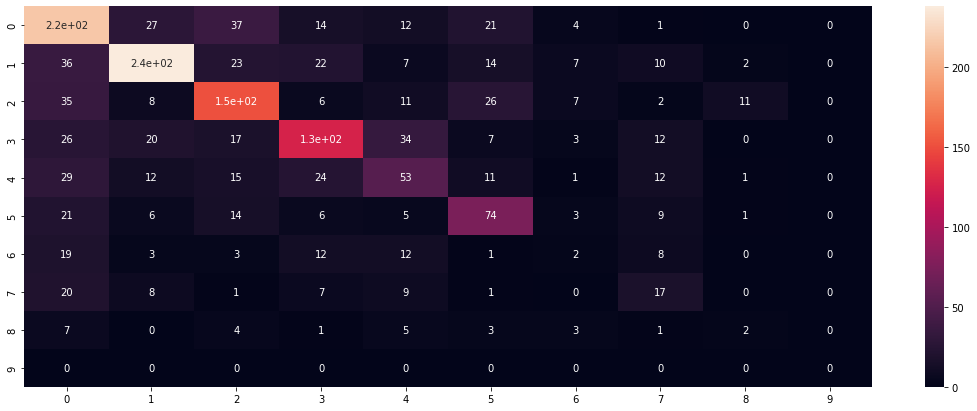

In [12]:
model = torch.load('baseline_model.pt')
acc, cf_mat = eval(cf=True)
plt.figure(figsize = (19, 7))
sn.heatmap(cf_mat, annot=True)